In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import tensorflow as tf

SEED = 1


def set_seed(seed=SEED):
    tf.keras.utils.set_random_seed(seed)


set_seed()
import cv2
import matplotlib.patches as patches
import cv2
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import layers
from keras.applications.resnet import preprocess_input
from keras.applications import ResNet50
from keras.layers import Input, Flatten, Dense, Concatenate, Activation, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [4]:
data = pd.read_csv(
    'datasets/styles.csv',
    on_bad_lines='skip'
)

data = data.dropna()
data = pd.DataFrame(data)

image_path = 'datasets/images'

In [5]:
data

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume


In [6]:
def show_k_random(k, name):
    choices = np.random.choice(data.index, k, replace=False)
    choices = data.loc[choices, ['id', name]]
    fig, axs = plt.subplots(1, k, figsize=(15, 10))
    for this_name, id, ax in zip(choices[name], choices['id'], axs.ravel()):
        img_path = f"{image_path}/{id}.jpg"
        img = plt.imread(img_path)
        ax.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'{this_name}')
    plt.tight_layout()
    plt.show()

gender


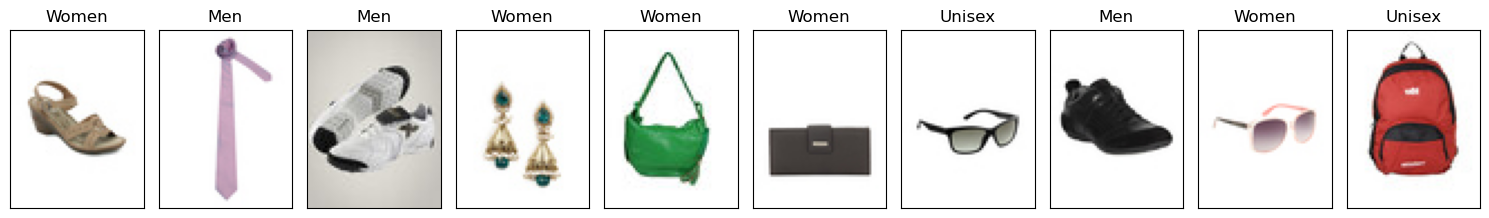

masterCategory


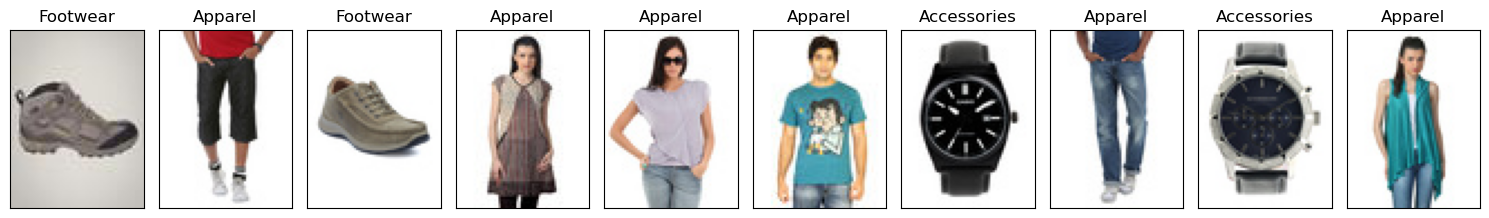

subCategory


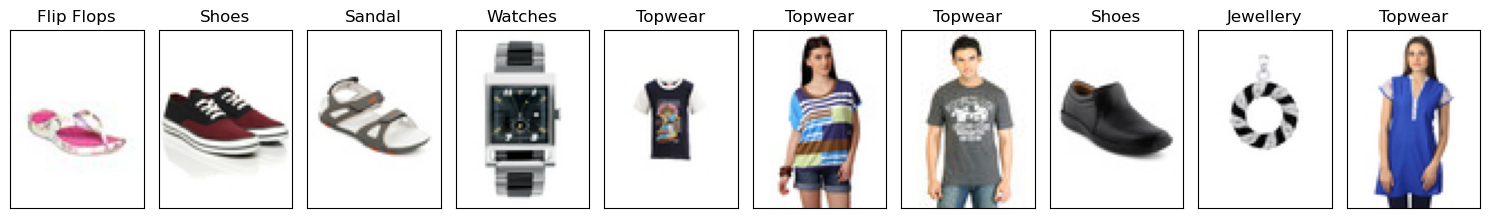

articleType


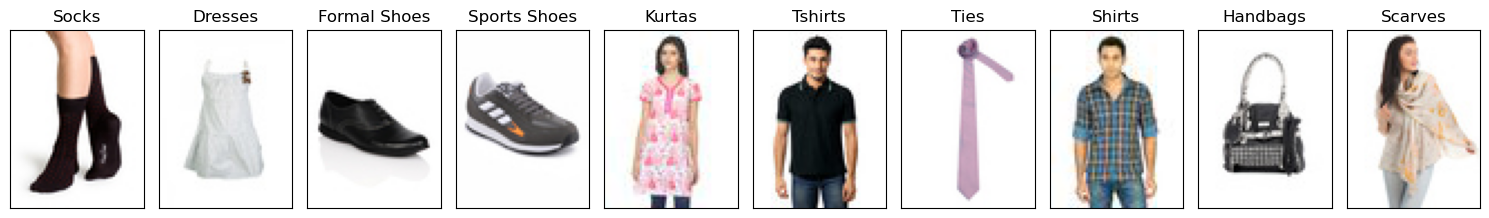

baseColour


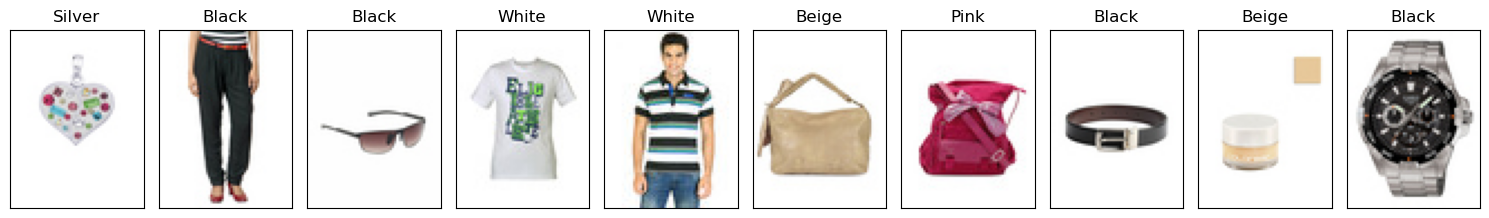

season


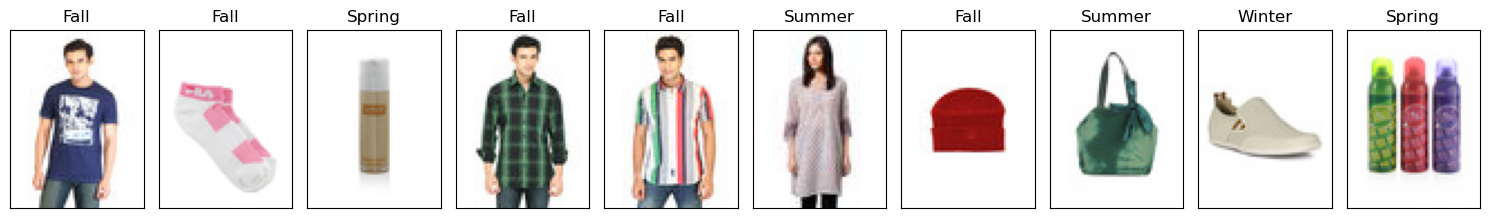

year


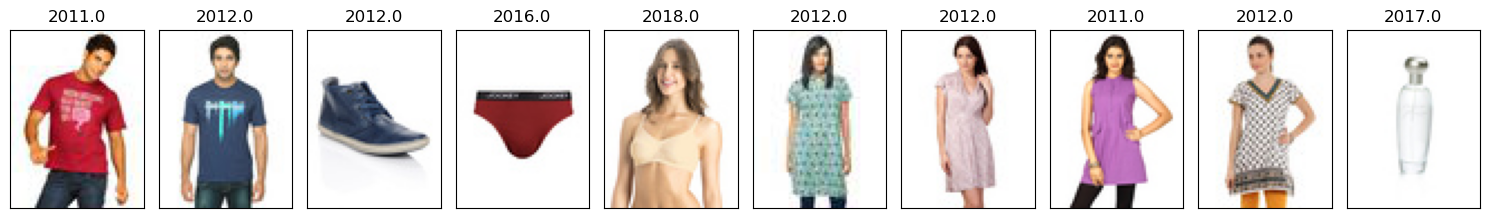

usage


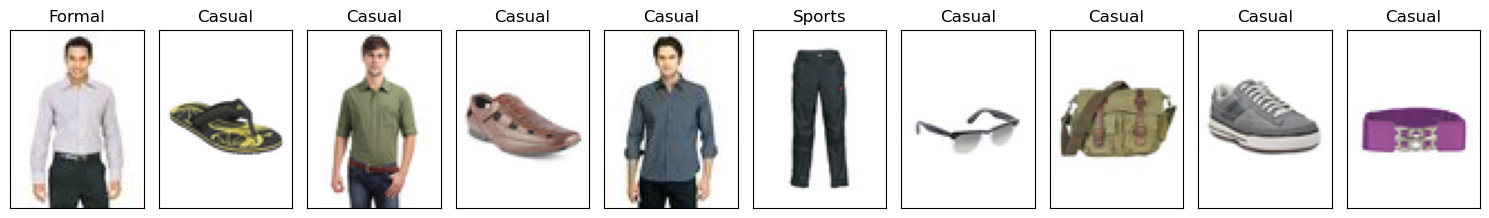

In [7]:
labels = data.columns[1:-1]
for col in labels:
    print(col)
    show_k_random(10, col)

In [8]:
from matplotlib.pyplot import get_figlabels


new_data = []

if os.path.exists('datasets/data_labels.csv'):
    print('Loading...')
    new_data = pd.read_csv('datasets/data_labels.csv')
else:
    for i, row in tqdm(data.iterrows(), total=data.shape[0]):
        path = f"{image_path}/{row['id']}.jpg"
        if os.path.exists(path):
            new_data.append(get_figlabels(row))

print(f'Successfully loaded images: {len(new_data)} ({len(new_data) / len(data) * 100}%)')

Loading...
Successfully loaded images: 44072 (99.98865621525967%)


In [9]:
data_labels = pd.DataFrame(new_data)
data_labels.to_csv('data_labels.csv', index=False)
data_labels

,id,path,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage
0,15970,/kaggle/input/fashion-product-images-small/ima...,1,1,1,1,1,1,1,1
1,39386,/kaggle/input/fashion-product-images-small/ima...,1,1,2,2,2,2,2,1
2,59263,/kaggle/input/fashion-product-images-small/ima...,2,2,3,3,3,3,3,1
3,21379,/kaggle/input/fashion-product-images-small/ima...,1,1,2,4,4,1,1,1
4,53759,/kaggle/input/fashion-product-images-small/ima...,1,1,1,5,5,2,2,1
...,...,...,...,...,...,...,...,...,...,...
44067,17036,/kaggle/input/fashion-product-images-small/ima...,1,3,5,7,8,2,8,1
44068,6461,/kaggle/input/fashion-product-images-small/ima...,1,3,7,9,17,2,1,1
44069,18842,/kaggle/input/fashion-product-images-small/ima...,1,1,1,5,2,1,1,1
44070,46694,/kaggle/input/fashion-product-images-small/ima...,2,4,12,27,2,4,4,1


In [13]:
IMAGE_SIZE = [80, 60]

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'gender'}>,
        <Axes: title={'center': 'masterCategory'}>],
       [<Axes: title={'center': 'subCategory'}>,
        <Axes: title={'center': 'articleType'}>,
        <Axes: title={'center': 'baseColour'}>],
       [<Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'usage'}>]], dtype=object)

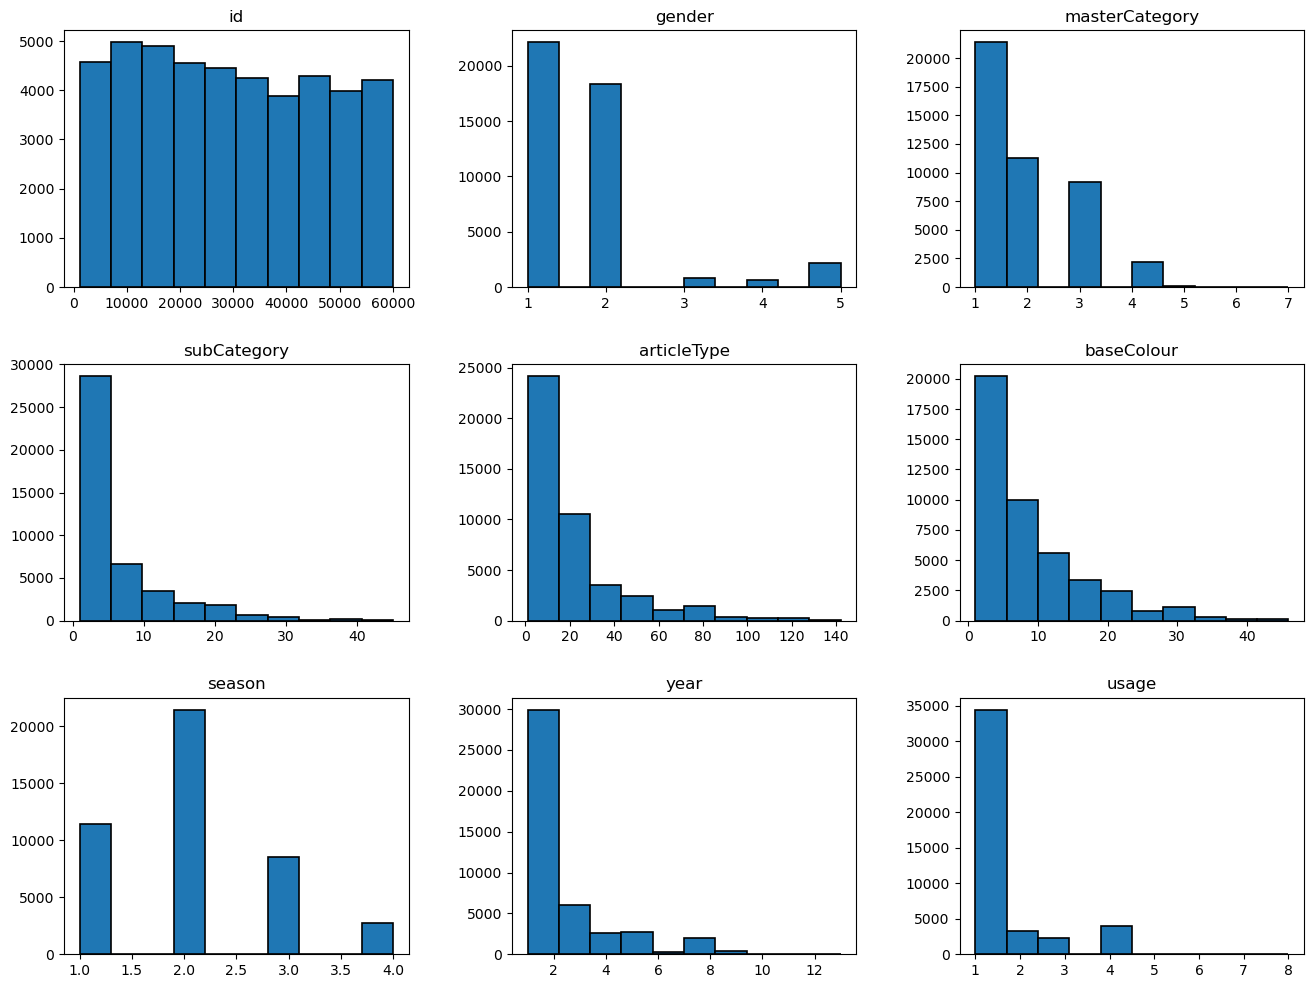

In [10]:
data_labels.hist(figsize=(16, 12), grid=False, edgecolor='black', linewidth=1.2)

In [11]:
color_map = {
    # Neutral Tones
    'Beige': 'Brown',
    'Black': 'Black',
    'Charcoal': 'Gray',
    'Cream': 'White',
    'Grey': 'Gray',
    'Grey Melange': 'Gray',
    'Khaki': 'Brown',
    'Mushroom Brown': 'Brown',
    'Nude': 'Brown',
    'Off White': 'White',
    'Silver': 'Gray',
    'Steel': 'Gray',
    'Tan': 'Brown',
    'Taupe': 'Brown',
    'White': 'White',

    # Red and Pink Tones
    'Burgundy': 'Red',
    'Maroon': 'Red',
    'Mauve': 'Pink',
    'Pink': 'Pink',
    'Rose': 'Pink',
    'Red': 'Red',

    # Orange and Brown Tones
    'Bronze': 'Brown',
    'Brown': 'Brown',
    'Coffee Brown': 'Brown',
    'Copper': 'Brown',
    'Rust': 'Brown',

    # Yellow Tones
    'Gold': 'Yellow',
    'Mustard': 'Yellow',
    'Peach': 'Yellow',
    'Yellow': 'Yellow',

    # Green Tones
    'Fluorescent Green': 'Green',
    'Green': 'Green',
    'Lime Green': 'Green',
    'Olive': 'Green',
    'Sea Green': 'Green',

    # Blue Tones
    'Blue': 'Blue',
    'Navy Blue': 'Blue',
    'Teal': 'Blue',
    'Turquoise Blue': 'Blue',

    # Purple and Violet Tones
    'Lavender': 'Purple',
    'Magenta': 'Purple',
    'Purple': 'Purple',

    # Orange Tones
    'Orange': 'Brown',

    # Unique/Other Colors
    'Metallic': 'Gray',
    'Multi': 'Multi',
    'Skin': 'Yellow',
}

old_colors = zip(data['id'], data['baseColour'])
new_colors = {}
for id, color in old_colors:
    new_colors[id] = color_map[color]

In [12]:
data_labels['baseColour'] = data_labels['id'].map(new_colors)
data_labels

,id,path,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage
0,15970,/kaggle/input/fashion-product-images-small/ima...,1,1,1,1,Blue,1,1,1
1,39386,/kaggle/input/fashion-product-images-small/ima...,1,1,2,2,Blue,2,2,1
2,59263,/kaggle/input/fashion-product-images-small/ima...,2,2,3,3,Gray,3,3,1
3,21379,/kaggle/input/fashion-product-images-small/ima...,1,1,2,4,Black,1,1,1
4,53759,/kaggle/input/fashion-product-images-small/ima...,1,1,1,5,Gray,2,2,1
...,...,...,...,...,...,...,...,...,...,...
44067,17036,/kaggle/input/fashion-product-images-small/ima...,1,3,5,7,White,2,8,1
44068,6461,/kaggle/input/fashion-product-images-small/ima...,1,3,7,9,Red,2,1,1
44069,18842,/kaggle/input/fashion-product-images-small/ima...,1,1,1,5,Blue,1,1,1
44070,46694,/kaggle/input/fashion-product-images-small/ima...,2,4,12,27,Blue,4,4,1


In [14]:
data_labels['baseColour'] = data_labels['id'].map(new_colors)
data_labels

,id,path,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage
0,15970,/kaggle/input/fashion-product-images-small/ima...,1,1,1,1,Blue,1,1,1
1,39386,/kaggle/input/fashion-product-images-small/ima...,1,1,2,2,Blue,2,2,1
2,59263,/kaggle/input/fashion-product-images-small/ima...,2,2,3,3,Gray,3,3,1
3,21379,/kaggle/input/fashion-product-images-small/ima...,1,1,2,4,Black,1,1,1
4,53759,/kaggle/input/fashion-product-images-small/ima...,1,1,1,5,Gray,2,2,1
...,...,...,...,...,...,...,...,...,...,...
44067,17036,/kaggle/input/fashion-product-images-small/ima...,1,3,5,7,White,2,8,1
44068,6461,/kaggle/input/fashion-product-images-small/ima...,1,3,7,9,Red,2,1,1
44069,18842,/kaggle/input/fashion-product-images-small/ima...,1,1,1,5,Blue,1,1,1
44070,46694,/kaggle/input/fashion-product-images-small/ima...,2,4,12,27,Blue,4,4,1


<Axes: >

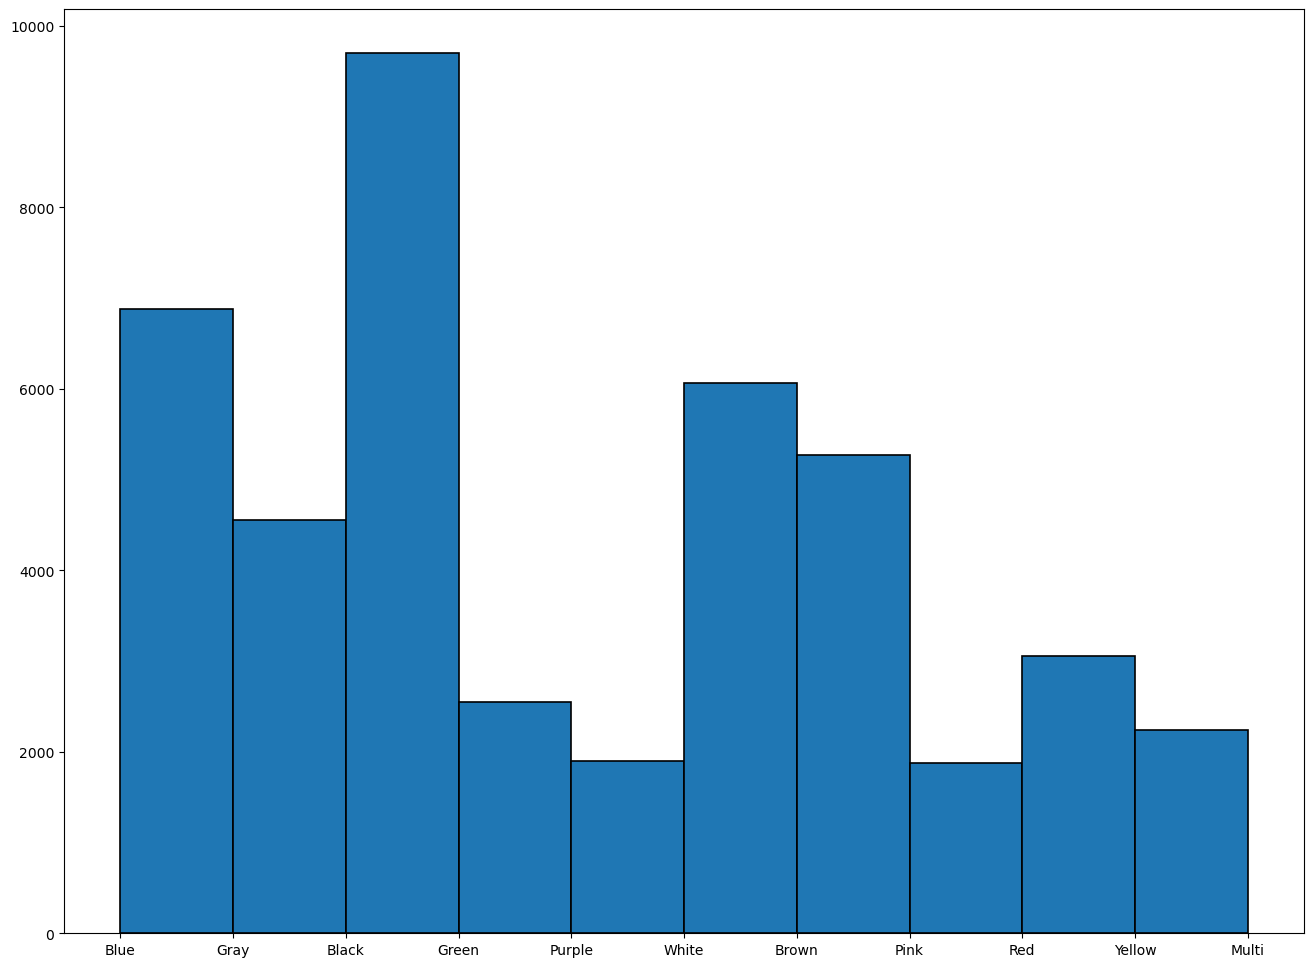

In [15]:
data_labels['baseColour'].hist(figsize=(16, 12), grid=False, edgecolor='black', linewidth=1.2)

In [16]:
labels_wo_col = list(labels)

In [17]:
labels_wo_col.remove('baseColour')

In [18]:
merged_df = data_labels.merge(data.drop(columns=['productDisplayName']), on='id', how='left', suffixes=('_replace', ''))
merged_df = merged_df.drop(columns=[f'{label}_replace' for label in labels])
merged_df['baseColour'] = merged_df['id'].map(new_colors)
data_labels = merged_df

In [161]:
pip install --upgrade ipywidgets


Note: you may need to restart the kernel to use updated packages.


In [19]:
data_labels['path'] = data_labels['id'].apply(lambda x: f"{image_path}/{x}.jpg")


In [20]:
print(IMAGE_SIZE)  # Should print something like (224, 224)


[80, 60]


In [21]:
print(data_labels.head())  # Should show a DataFrame with 'path' column


      id                       path gender masterCategory subCategory  \
0  15970  datasets/images/15970.jpg    Men        Apparel     Topwear   
1  39386  datasets/images/39386.jpg    Men        Apparel  Bottomwear   
2  59263  datasets/images/59263.jpg  Women    Accessories     Watches   
3  21379  datasets/images/21379.jpg    Men        Apparel  Bottomwear   
4  53759  datasets/images/53759.jpg    Men        Apparel     Topwear   

   articleType baseColour  season    year   usage  
0       Shirts       Blue    Fall  2011.0  Casual  
1        Jeans       Blue  Summer  2012.0  Casual  
2      Watches       Gray  Winter  2016.0  Casual  
3  Track Pants      Black    Fall  2011.0  Casual  
4      Tshirts       Gray  Summer  2012.0  Casual  


In [24]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.applications.resnet50 import preprocess_input

# Define paths
CSV_FILE_PATH = "datasets/styles_cleaned.csv"  # Local dataset
IMAGE_FOLDER = "datasets/images"  # Local images directory
IMAGE_DATA_PATH = "./image_data.npy"

# Load dataset
data = pd.read_csv(CSV_FILE_PATH, on_bad_lines="skip")
data = data.dropna()
data = pd.DataFrame(data)

# Fix the image paths and ensure they are formatted correctly
data["path"] = data["id"].astype(str).apply(lambda x: os.path.join(IMAGE_FOLDER, f"{x}.jpg"))

# Normalize paths for cross-platform compatibility
data["path"] = data["path"].apply(lambda x: os.path.normpath(x))

# Check if the paths are updated correctly
print(data.head())  # Debugging step

# Define image size
IMAGE_SIZE = (80, 60)

# Function to load and preprocess an image
def load_image(imagePath, image_size=IMAGE_SIZE):
    if not os.path.exists(imagePath):
        print(f"⚠️ Warning: Image file not found at {imagePath}")
        return None  # Skip missing images

    image = cv2.imread(imagePath)
    
    if image is None:
        print(f"⚠️ Warning: Unable to read image at {imagePath}")
        return None  # Skip this image

    image = cv2.resize(image, (image_size[1], image_size[0]))  # Resize to expected size
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = preprocess_input(image)  # Normalize for the model
    return image

# Load images and save them if not already saved
if os.path.exists(IMAGE_DATA_PATH):
    os.remove(IMAGE_DATA_PATH)  # Delete old npy file

image_data = []

for path in tqdm(data["path"]):
    img = load_image(path)
    if img is not None:  # Only append valid images
        image_data.append(img)

if len(image_data) == 0:
    raise RuntimeError("❌ No valid images found. Check dataset paths.")

image_data = np.array(image_data, dtype="float32")  # Convert to NumPy array
np.save(IMAGE_DATA_PATH, image_data)  # Save to disk
print(f"✅ Image data saved successfully to {IMAGE_DATA_PATH}.")


      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  \
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt   
1  2012.0  Casual             Peter England Men Party Blue Jeans   
2  2016.0  Casual                       Titan Women Silver Watch   
3  2011.0  Casual  Manchester United Men Solid Black Track Pants   
4  2012.0  Casual                          Puma Men Grey T-shirt   

                        path  
0  datasets\images\15970.jpg  
1  datasets\images\39386.jpg  
2  datasets\images\59263.jpg 

100%|██████████| 44072/44072 [01:43<00:00, 426.24it/s]


✅ Image data saved successfully to ./image_data.npy.


In [25]:
y_binarized = []
LB = {}
for label in labels:
    LB[label] = LabelBinarizer()
    y_binarized.append(LB[label].fit_transform(np.array(data_labels[label])))

In [26]:
split = train_test_split(image_data, *y_binarized, test_size=0.3, random_state=SEED)


In [27]:
X_train, X_test = split[0], split[1]
X_val, X_test = train_test_split(X_test, test_size=(0.1 / 0.3), random_state=SEED)
y_train = {}
y_val = {}
y_test = {}
for i in range(2, len(split), 2):
    name = labels[i // 2 - 1]
    x, y = split[i], split[i + 1]
    y, z = train_test_split(y, test_size=(0.1 / 0.3), random_state=SEED)
    y_train[f'{name}_top'] = x
    y_val[f'{name}_top'] = y
    y_test[f'{name}_top'] = z

In [28]:
def build_resnet_based_model(labels, n_outs, concats, image_size=IMAGE_SIZE):
    def make_top(before_top, n_out, name):
        z = Dense(n_out)(before_top)
        z = Activation('softmax', name=f'{name}_top')(z)
        return z

    def make_branch(res_input, name, n_out):
        z = Dense(n_out*8, activation='relu')(res_input)
        z = Dense(n_out*4, activation='relu')(z)
        z = Dense(n_out*2, activation='relu')(z)
        z = Dense(n_out, activation='relu', name=f'{name}_out')(z)
        return z

    def make_concat(inp_main, inp_other, name_main, name_other):
        z = Concatenate(name=f'{name_main}_{name_other}_cat')([inp_main, inp_other])
        z = Dense(128, activation='relu')(z)
        z = Dense(128, activation='relu')(z)
        return z

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    base_model.trainable = False
    
    inputs = Input(shape=(*image_size, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)

    branches = {}
    for label in labels:
        branches[label] = make_branch(x, label, n_outs[label])

    befores = {}
    for main, other in concats:
        befores[main] = make_concat(
            branches[main], branches[other],
            main, other
        )

    outputs = []
    for label in labels:
        if label in befores:
            outputs.append(make_top(befores[label], n_outs[label], label))
        else:
            outputs.append(make_top(branches[label], n_outs[label], label))

    model = Model(inputs=inputs, outputs=outputs, name='ResnetBased')

    return model

In [29]:
# Dependencies
concats = [
    ('subCategory', 'masterCategory'),
    ('baseColour', 'masterCategory')
]

# Number of outputs
n_outs = {}
for label in labels:
    n_outs[label] = len(np.unique(data_labels[label]))

In [30]:
EPOCHS = 25
INIT_LR = 1e-4
BS = 64

In [31]:
def get_model(model_path, history_path):
    if os.path.exists(model_path) and os.path.exists(history_path):
        model = keras.models.load_model(model_path)
        frame = pd.read_csv(history_path)
        return model, frame
    
    model = build_resnet_based_model(labels, n_outs, concats)

    losses = {}
    for label in labels:
        losses[f'{label}_top'] = "categorical_crossentropy"

    metrics = {}
    for label in labels:
        metrics[f'{label}_top'] = "accuracy"

    # Construct class weights dictionary
    # class_weight_dict = {label: class_weights[label] for label in df.columns[1:]}

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=INIT_LR,
        decay_steps=10000,
        decay_rate=0.99)

    opt = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=opt, loss=losses, metrics=metrics)
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(
            X_val, y_val
        ),
        epochs=EPOCHS,
        batch_size=BS,
        callbacks=[early_stopping]
    )
    
    model.save(model_path)
    frame = pd.DataFrame(history.history)
    frame.to_csv(history_path)
    
    return model, frame

model, frame = get_model('resnet_based.keras', 'history_resnet.csv')

In [173]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


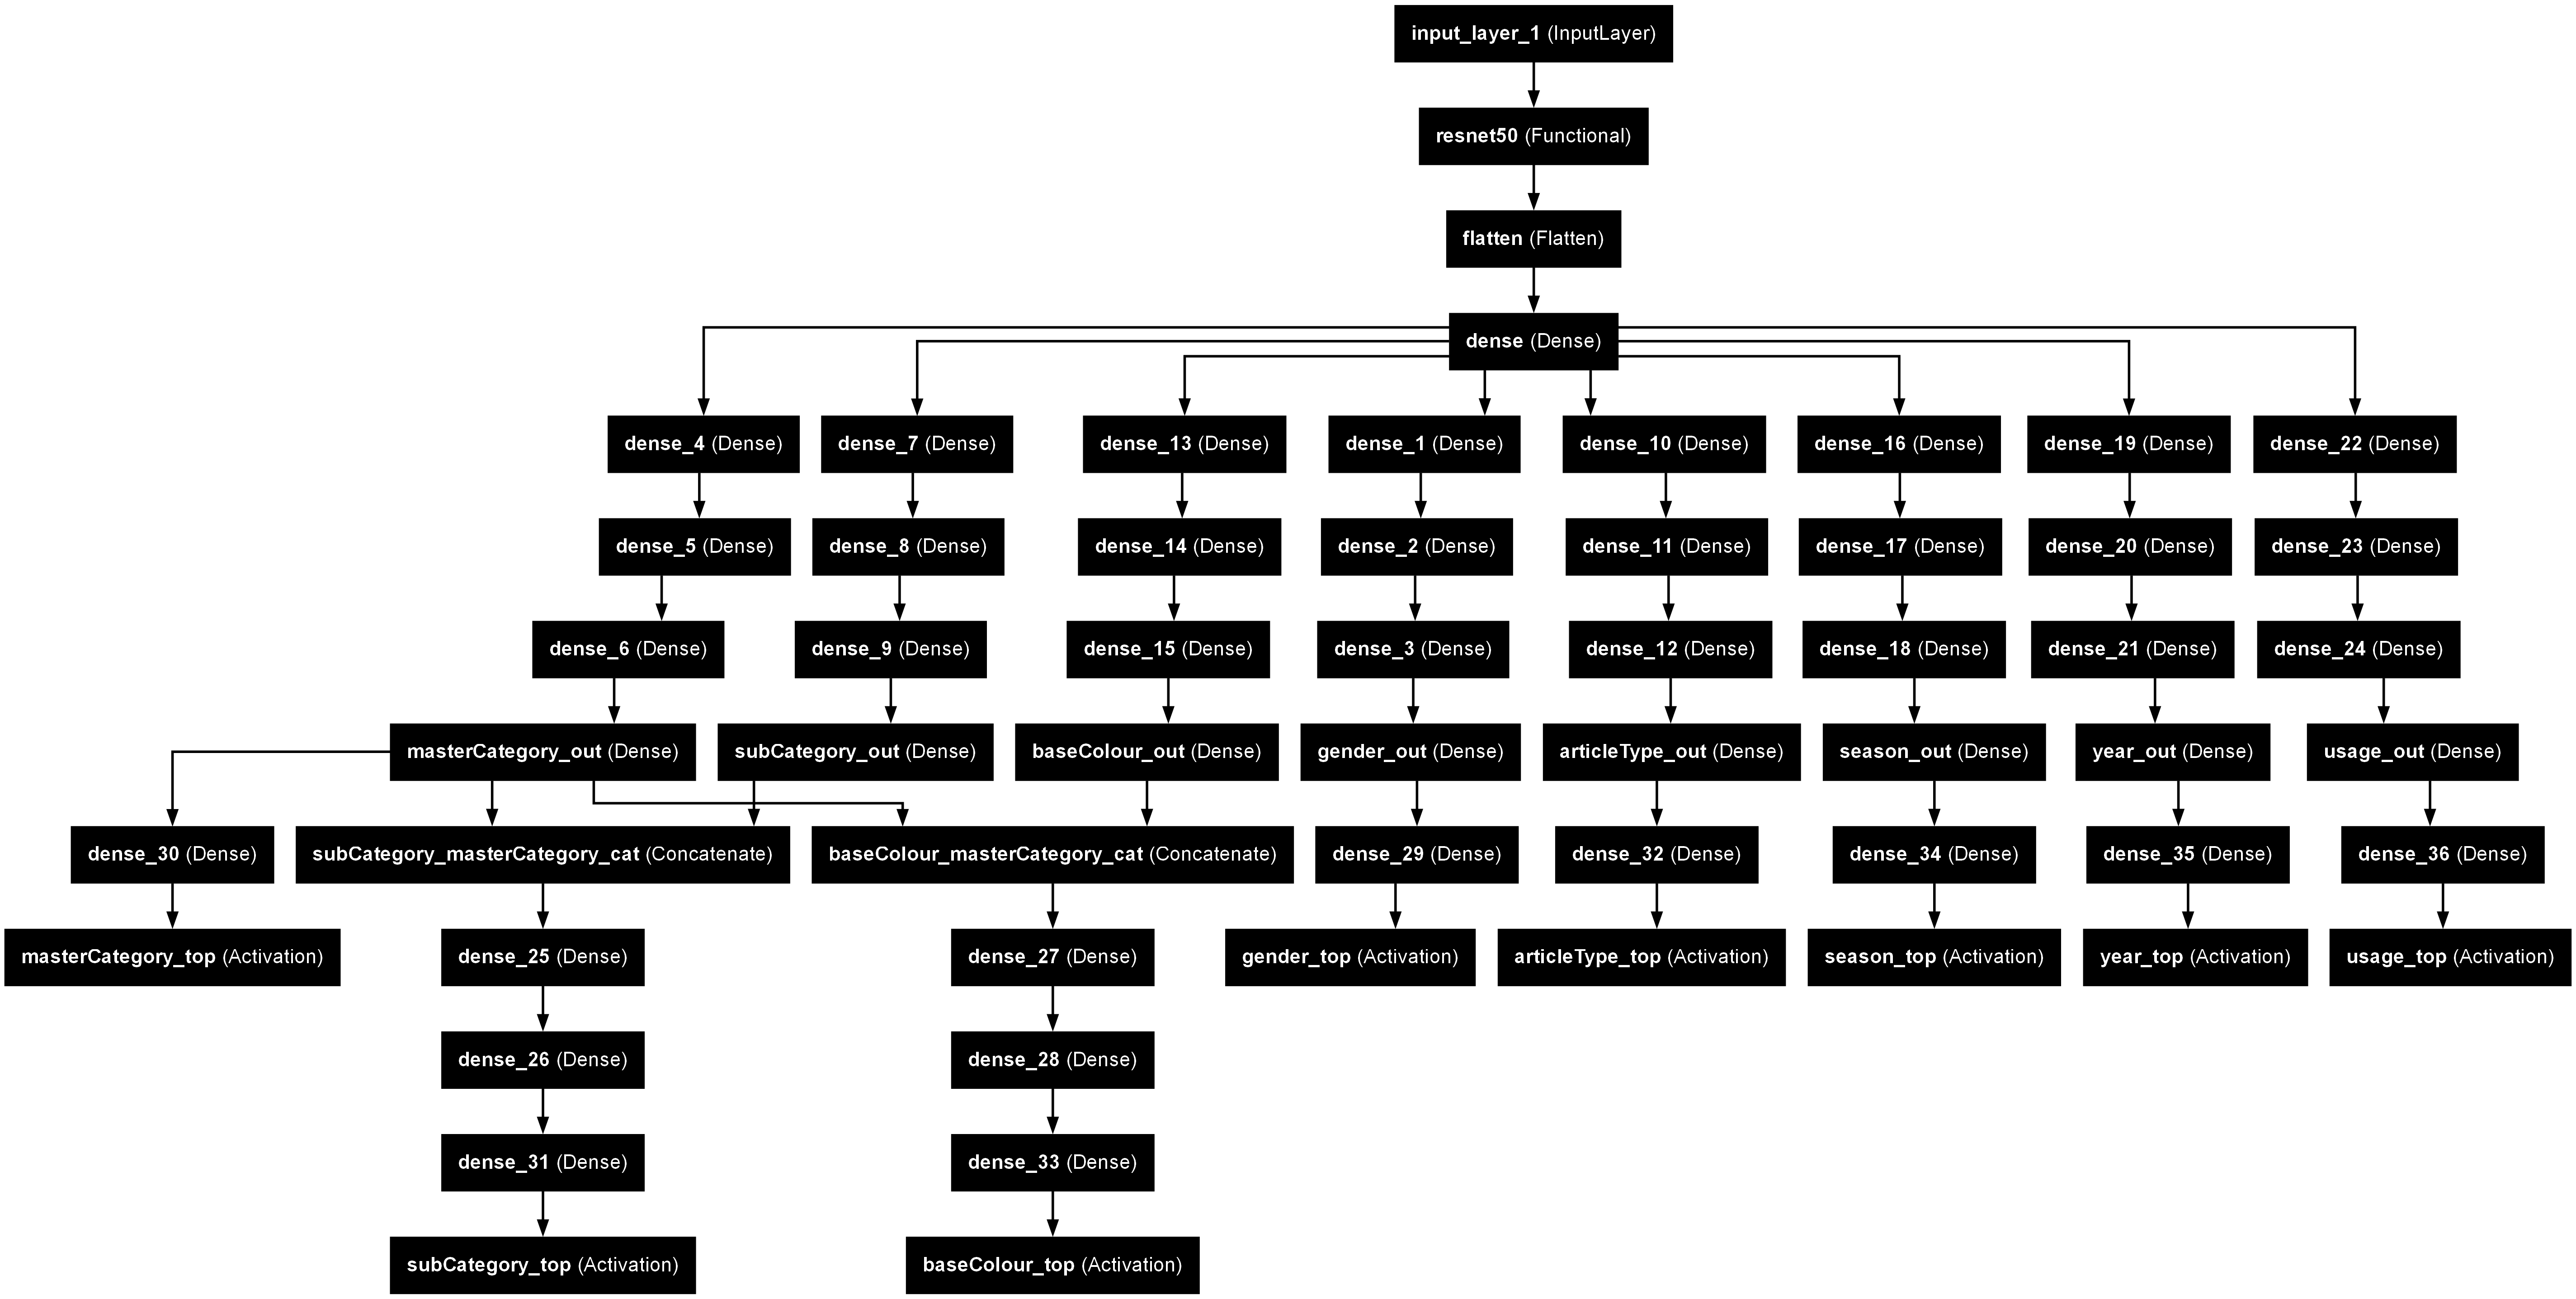

In [28]:
plot_model(model, show_layer_names=True)

In [175]:
model.summary()

Model: "ResnetBased"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 80, 60, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 3, 2,      │ 23,587,712 │ input_layer_1[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12288)     │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │ 12,583,936 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 56)        │     57,400 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 360)       │    369,000 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 88)        │     90,200 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 28)        │      1,596 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 180)       │     64,980 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 44)        │      3,916 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 14)        │        406 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 90)        │     16,290 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 22)        │        990 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 40)        │     41,000 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masterCategory_out  │ (None, 7)         │        105 │ dense_6[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subCategory_out     │ (None, 45)        │      4,095 │ dense_9[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1128)      │  1,156,200 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ baseColour_out      │ (None, 11)        │        253 │ dense_15[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32)        │     32,800 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 104)       │    106,600 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │     65,600 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20)        │        820 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 70,126,473 (267.51 MB)

 Trainable params: 15,512,920 (59.18 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 31,025,841 (118.35 MB)

In [32]:
plts = ['loss', *[f'{label}_top_accuracy' for label in labels]]
plts = [(p, f'val_{p}') for p in plts]

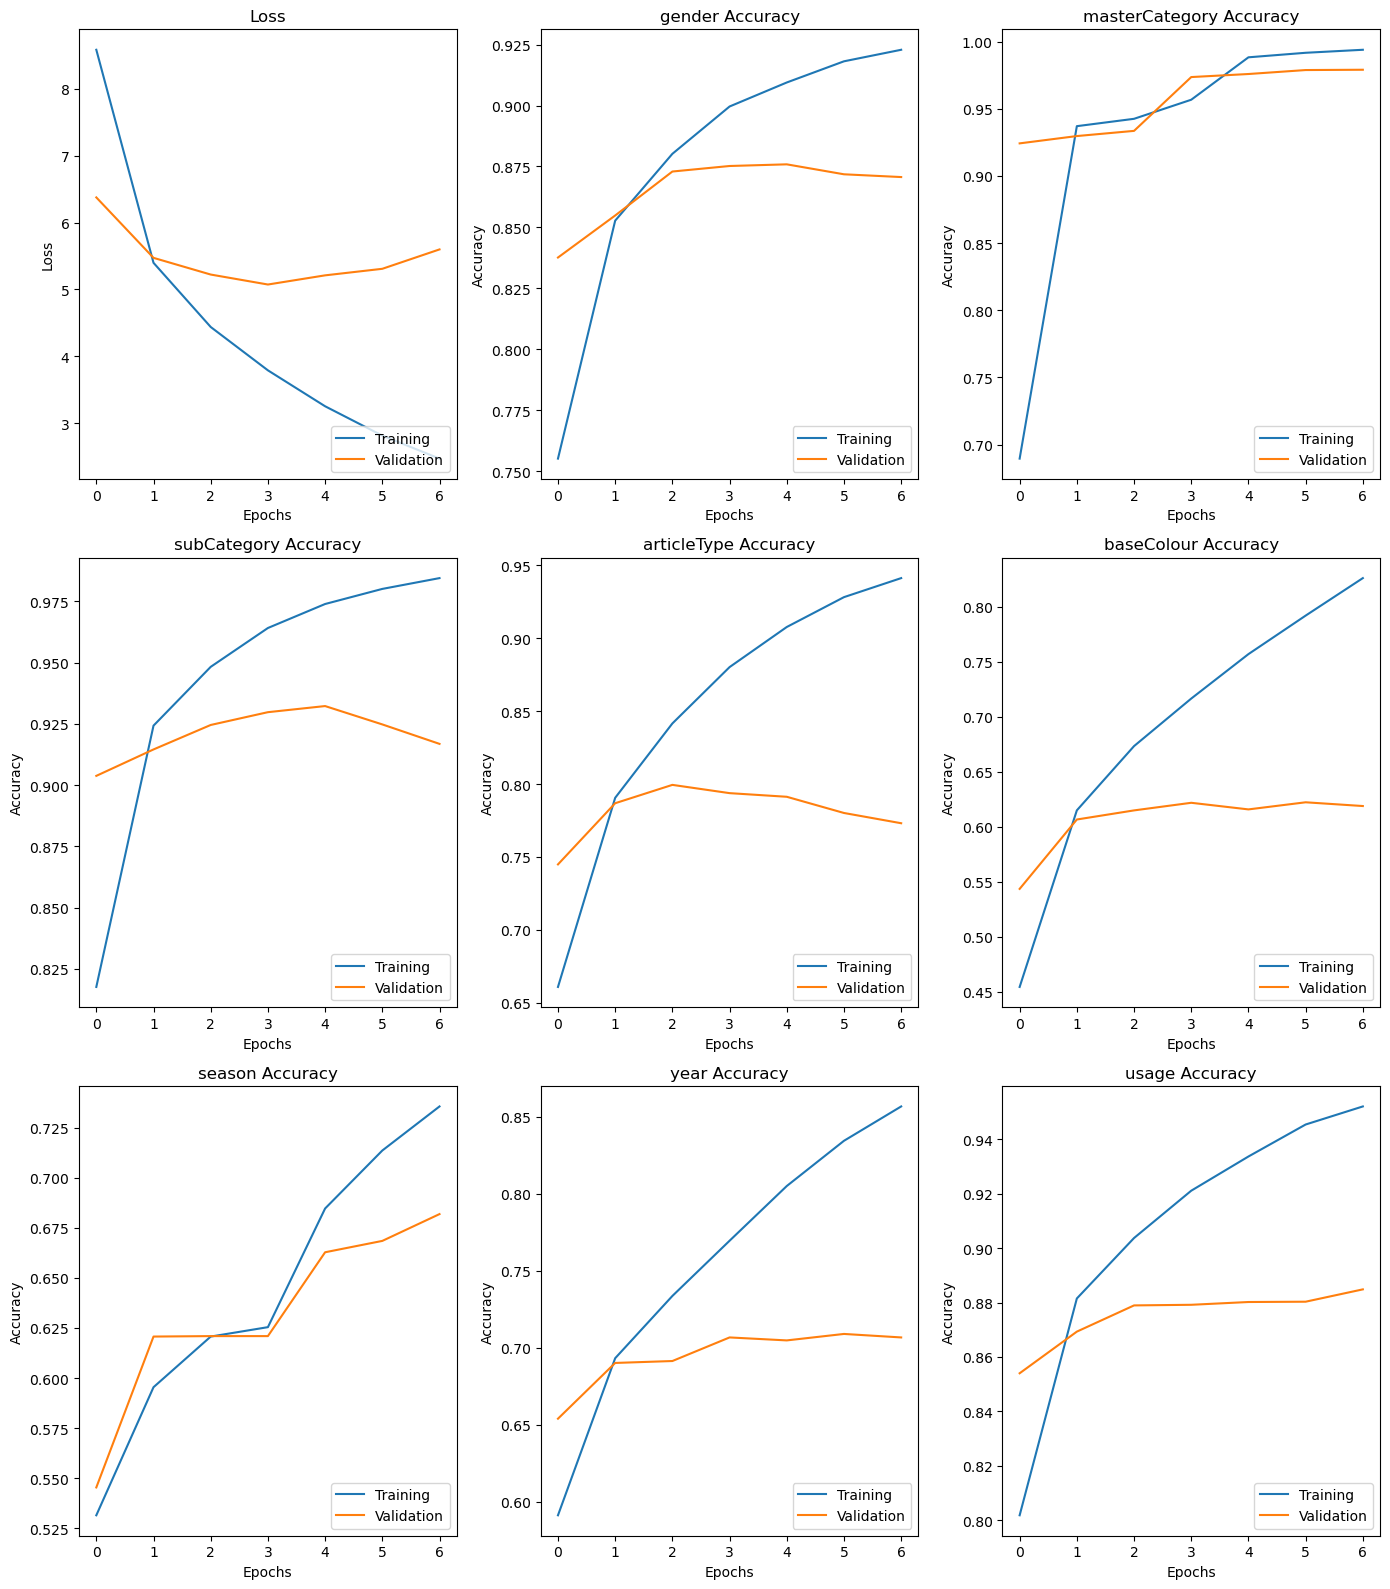

In [33]:
num_subplots = len(frame.columns) // 2
fig, axs = plt.subplots(num_subplots // 3, 3, figsize=(14, 16))

plts_v = {}

for i, (p, p_v) in enumerate(plts):
    name = p.replace('_top_accuracy', '')
    title = f'{name} Accuracy' if name != 'loss' else 'Loss'
    axs[i // 3, i % 3].set_title(title)
    values_train = frame[p]
    values_valid = frame[p_v]
    plts_v[name] = list(values_valid)[-1]
    axs[i // 3, i % 3].plot(values_train, label='Training')
    axs[i // 3, i % 3].plot(values_valid, label='Validation')
    axs[i // 3, i % 3].legend(loc='lower right')
    axs[i // 3, i % 3].set_xlabel('Epochs')
    axs[i // 3, i % 3].set_ylabel('Accuracy' if name != 'loss' else 'Loss')

plt.tight_layout()
plt.show()

In [34]:
res = model.evaluate(X_test, y_test, batch_size=BS, verbose=0)

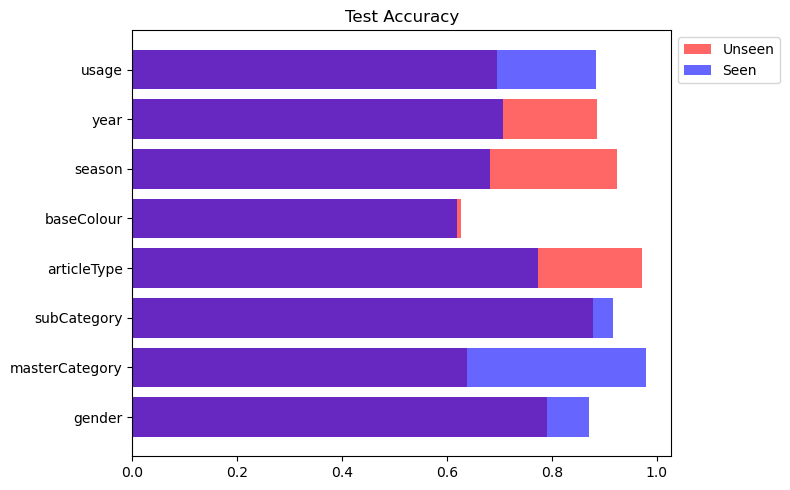

In [35]:
plt_x = labels
plt_y = res[1:]
plt_yv = [plts_v[l] for l in labels]
plt.figure(figsize=(8, 5))
plt.barh(plt_x, plt_y, color='red', alpha=0.6, label='Unseen')
plt.barh(plt_x, plt_yv, color='blue', alpha=0.6, label='Seen')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Test Accuracy')
plt.tight_layout()
plt.show()

In [36]:
def predict_labels(image_path):
    image = load_image(image_path)
    image = np.expand_dims(image, axis=0)
    output_probs = model.predict(image, verbose=0)
    predicted_classes = {}
    for i, probs in enumerate(output_probs):
        out = LB[labels[i]].inverse_transform(np.array(probs == probs.max(), dtype=np.int64))
        out = str(out[0])
        predicted_classes[labels[i]] = out
    return predicted_classes

def predict_and_show(imagePath):
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    l = predict_labels(imagePath)
    plt.title(' | '.join(list(l.values())))
    plt.axis('off')
    plt.imshow(image)

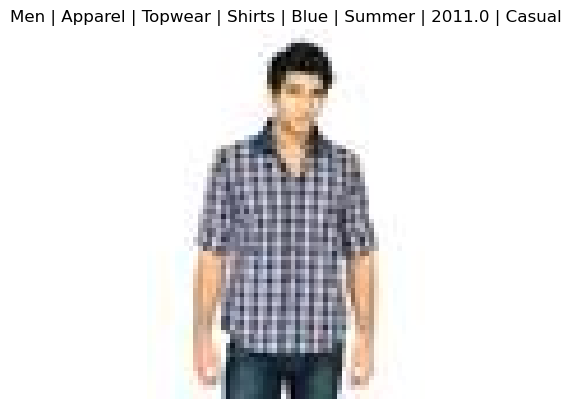

In [37]:
predict_and_show(data_labels['path'][0])

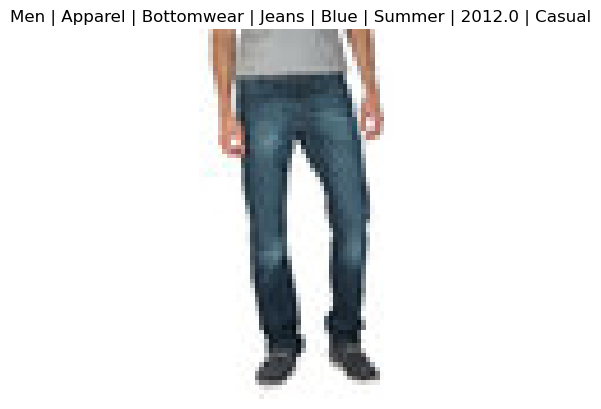

In [38]:
predict_and_show(data_labels['path'][1])

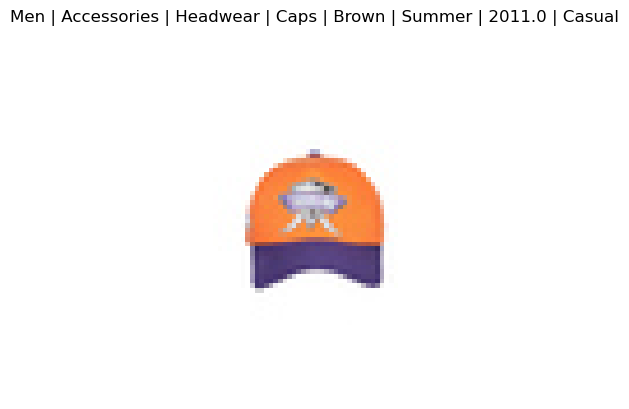

In [39]:
predict_and_show(data_labels['path'][1210])

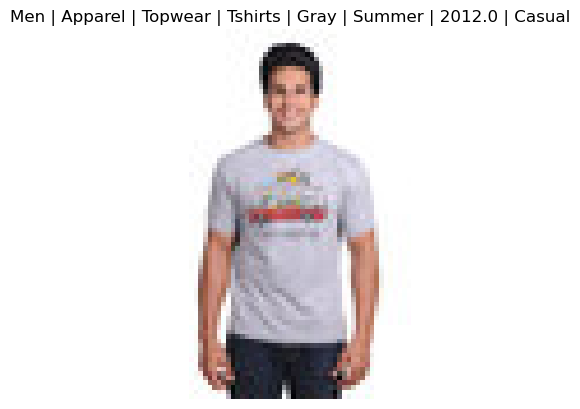

In [40]:
predict_and_show(data_labels['path'][5])

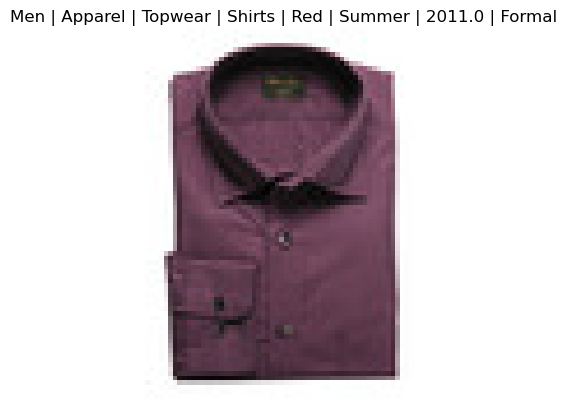

In [41]:
predict_and_show(data_labels['path'][15])

In [42]:
prompt_inputs = []
if os.path.exists('prompts_medium.csv'):
    print('Loading...')
    prompt_inputs = pd.read_csv('prompts_medium.csv')
else:
    for i, row in tqdm(data_labels.iterrows(), total=100):
        if i == 10000:
            break
        prompt_input = {}
        lbl = [str(l) for l in list(row[2:])]
        lbl = ', '.join(lbl)
        prompt_input['labels'] = lbl
        caption = data.loc[data['id'] == row['id'], 'productDisplayName'].values
        if caption.size == 0:
            continue
        prompt_input['caption'] = caption[0]
        prompt_inputs.append(prompt_input)
    prompt_inputs = pd.DataFrame(prompt_inputs)
    prompt_inputs.to_csv('prompts_medium.csv', index=False)

Loading...


In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Tokenize labels
label_tokenizer = Tokenizer()
flattened_labels = list(prompt_inputs['labels'])
label_tokenizer.fit_on_texts(flattened_labels)
label_sequences = label_tokenizer.texts_to_sequences(flattened_labels)
max_label_length = max(len(seq) for seq in label_sequences)
label_sequences = pad_sequences(label_sequences, maxlen=max_label_length, padding='post')

# Tokenize captions
caption_tokenizer = Tokenizer()
captions = list(prompt_inputs['caption'])
caption_tokenizer.fit_on_texts(captions)
caption_sequences = caption_tokenizer.texts_to_sequences(captions)
max_caption_length = max(len(seq) for seq in caption_sequences)
caption_sequences = pad_sequences(caption_sequences, maxlen=max_caption_length, padding='post')

# Convert to numpy arrays
X = np.array(label_sequences)
y = np.array(caption_sequences)
# y = np.array([to_categorical(seq, num_classes=len(caption_tokenizer.word_index) + 1) for seq in y])

print("Label sequences:\n", X)
print("Caption sequences:\n", y)

Label sequences:
 [[ 3  5  8 ...  0  0  0]
 [ 3  5 31 ...  0  0  0]
 [ 6 12 22 ...  0  0  0]
 ...
 [ 3 12 54 ...  0  0  0]
 [ 3 12 54 ...  0  0  0]
 [ 6  5  8 ...  0  0  0]]
Caption sequences:
 [[ 281   36    1 ...    0    0    0]
 [ 118  119    1 ...    0    0    0]
 [ 186    2   37 ...    0    0    0]
 ...
 [ 679    1 3955 ...    0    0    0]
 [ 341    1   10 ...    0    0    0]
 [ 265    2  227 ...    0    0    0]]


In [44]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, TimeDistributed, BatchNormalization
from keras.optimizers import Adam

vocab_size = len(caption_tokenizer.word_index) + 1

def get_caption_model(model_path, frame_path):
    if os.path.exists(model_path) and os.path.exists(frame_path):
        model_caption = keras.models.load_model(model_path)
        frame_caption = pd.read_csv(frame_path)
        return model_caption, frame_caption
    # Define the model
    model_caption = Sequential([
        Embedding(input_dim=len(label_tokenizer.word_index) + 1, output_dim=256),
        Bidirectional(LSTM(256, return_sequences=True)),
        LSTM(256, return_sequences=True),
        BatchNormalization(),
        LSTM(128, return_sequences=True),
        BatchNormalization(),
        TimeDistributed(Dense(128, activation='relu')),
        TimeDistributed(Dense(128, activation='relu')),
        Dropout(0.2),
        TimeDistributed(Dense(vocab_size, activation='softmax'))
    ])

    lr_schedule_cap = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.99)

    # Compile the model
    model_caption.compile(optimizer=Adam(learning_rate=lr_schedule_cap), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train model
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model_caption.fit(X, y, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

    # Save the model for future use
    model_caption.save(model_path)
    frame = pd.DataFrame(history.history)
    frame.to_csv(frame_path)
    return model_caption, frame

In [45]:
model_caption, frame_caption = get_caption_model("caption_generator_model.keras", "caption_generator_history.csv")

In [46]:
model_caption.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 14, 256)        │        53,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 14, 512)        │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 14, 256)        │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 14, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 14, 128)        │        16,512 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 14, 128)        │        16,512 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 14, 3956)       │       510,324 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,899,229 (30.13 MB)

 Trainable params: 2,632,820 (10.04 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 5,265,641 (20.09 MB)

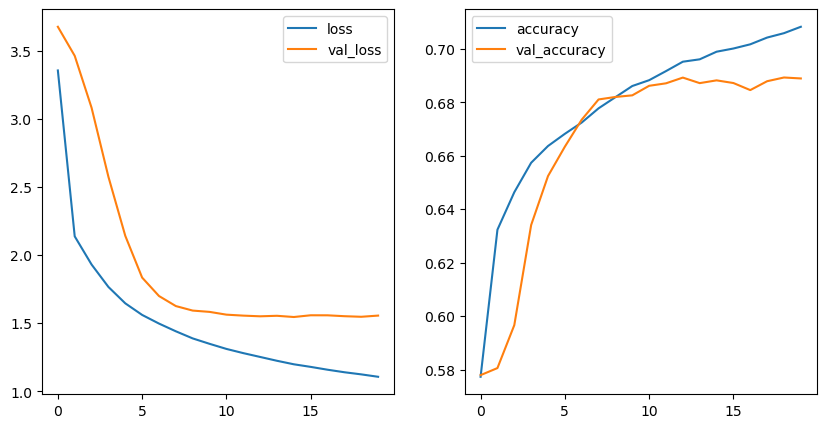

In [47]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
frame_caption.plot(y=['loss', 'val_loss'], ax=plt.gca())
plt.subplot(1, 2, 2)
frame_caption.plot(y=['accuracy', 'val_accuracy'], ax=plt.gca())
plt.show()

In [48]:
def predict_caption(path):
    new_labels = ', '.join(predict_labels(path).values())
    new_label_sequence = label_tokenizer.texts_to_sequences([new_labels])
    new_label_sequence = pad_sequences(new_label_sequence, maxlen=max_label_length, padding='post')

    # Predict caption
    predicted_sequence = model_caption.predict(new_label_sequence, verbose=0)
    predicted_caption = [np.argmax(word) for word in predicted_sequence[0]]
    pred = []
    for i in range(len(predicted_caption)):
        if i == 0 or predicted_caption[i] != predicted_caption[i-1]:
            pred.append(predicted_caption[i])
    predicted_text = caption_tokenizer.sequences_to_texts([pred])[0].title()
    return predicted_text

def predict_with_caption(imagePaths):
    # Set up the plot style
    sns.set(style="whitegrid")

    # Create a figure with a specific aspect ratio
    fig, axs = plt.subplots(
        2, len(imagePaths), 
        figsize=(5 * len(imagePaths), 10), 
        gridspec_kw={'height_ratios': [1, 1.8]}
    )
    

    for i, imagePath in enumerate(imagePaths):
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        l = predict_labels(imagePath)
        c = predict_caption(imagePath)

        # Prepare data for table
        labels = list(l.keys())
        values = list(l.values())
        df = pd.DataFrame({
            "Label": labels,
            "Predicted Value": values
        })
    
        # Plot the image
        axs[0, i].imshow(image)
        axs[0, i].axis('off')  # Hide the axis

        # Plot the table
        axs[1, i].axis('off')  # Hide the axis for the table

        # Create a table
        table = axs[1, i].table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center', colColours=["#ADD8E6", "#ADD8E6",  "#ADD8E6"])

        # Adjust table font and scaling for better visibility
        table.auto_set_font_size(False)
        table.set_fontsize(14)
        table.scale(2.5, 2.5)  # Adjust the scaling of the table
        table.auto_set_column_width(col=[0, 1])

        # Add a caption below the table
        axs[1, i].text(0.5, 0, c, wrap=True, horizontalalignment='center', fontsize=15, color='black')

        # Add a border around the table
        for key, cell in table.get_celld().items():
            cell.set_linewidth(1.5)
            cell.set_edgecolor('black')

    # Add grid and tight layout
    plt.tight_layout()  # Adjust rect to make room for suptitle

    # Show the plot
    plt.show()
    
def predict_four_random():
    choices = np.random.choice(data_labels['path'], 4, replace=False)
    predict_with_caption(choices)

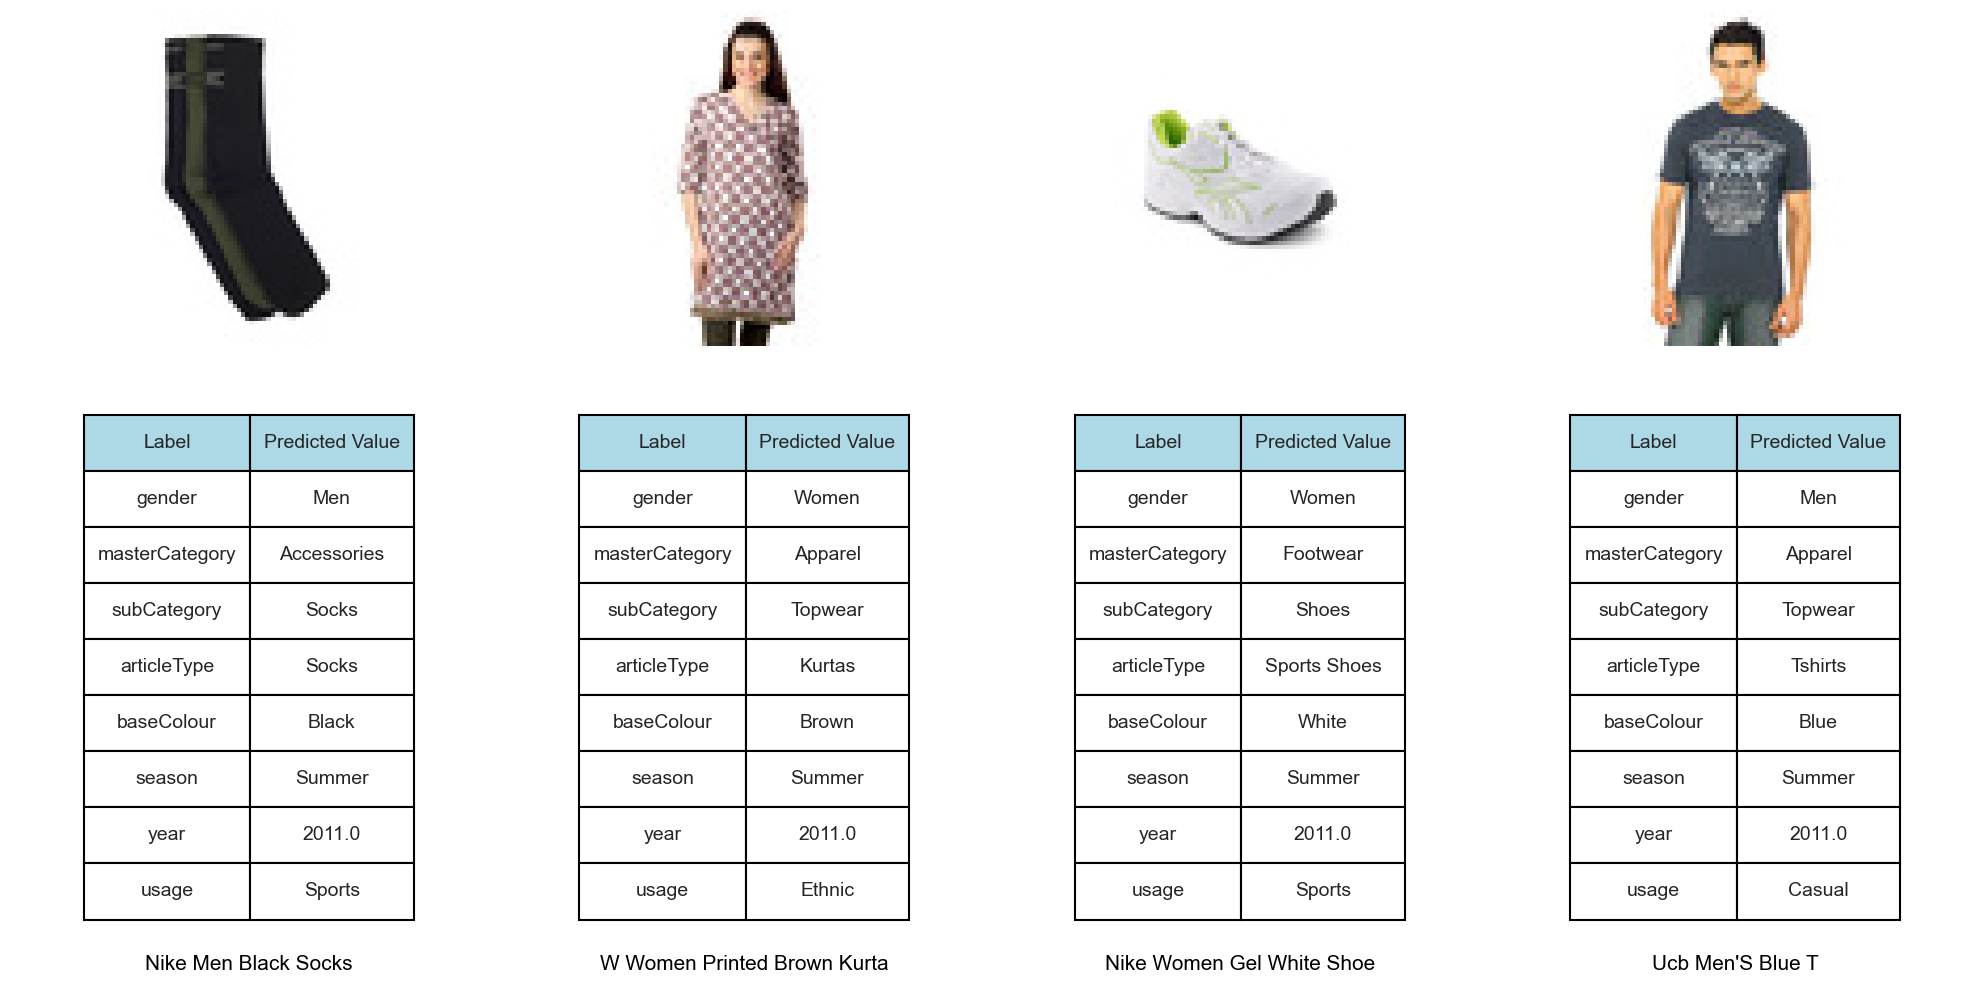

In [50]:
predict_four_random()

In [194]:
pip install kaggle


Note: you may need to restart the kernel to use updated packages.


In [195]:
import os

for root, dirs, files in os.walk('.'):
    for file in files:
        if 'tokenizer' in file:
            print(os.path.join(root, file))


.\amazon_tokenizer.pkl
.\caption_tokenizer.joblib
.\caption_tokenizer.pkl
.\label_tokenizer.joblib
.\label_tokenizer.pkl
.\tokenizer.pkl


In [51]:
import joblib

# Save label binarizers (use the same 'labels' variable from your notebook)
for label in labels:
    joblib.dump(LB[label], f'{label}_lb.joblib')

# Save tokenizers
joblib.dump(label_tokenizer, 'label_tokenizer.joblib')
joblib.dump(caption_tokenizer, 'caption_tokenizer.joblib')

# Save max lengths (you'll need these for inference)
import json
with open('config.json', 'w') as f:
    json.dump({
        'max_label_length': max_label_length,
        'max_caption_length': max_caption_length,
        'image_size': IMAGE_SIZE
    }, f)

In [52]:
import pickle

# Assuming you have already created your tokenizers
# Save label tokenizer
with open('label_tokenizer.pkl', 'wb') as f:
    pickle.dump(label_tokenizer, f)

# Save caption tokenizer
with open('caption_tokenizer.pkl', 'wb') as f:
    pickle.dump(caption_tokenizer, f)

In [53]:
predict_labels("shirt.jpg")

{'gender': 'Men',
 'masterCategory': 'Apparel',
 'subCategory': 'Topwear',
 'articleType': 'Shirts',
 'baseColour': 'Blue',
 'season': 'Summer',
 'year': '2011.0',
 'usage': 'Casual'}

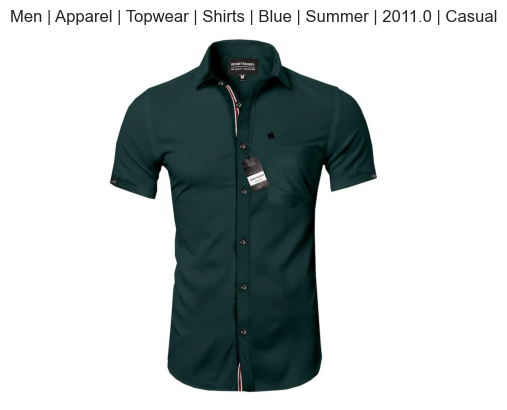

In [54]:
predict_and_show("shirt.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

📝 Review: 'This product is worst' → Predicted Sentiment: 0 (0)
❌ Negative sentiment detected. Skipping image recommendation.

📝 Review: 'This is really good' → Predicted Sentiment: 1 (1)
✅ Positive sentiment detected. Recommending similar items...


📸 Running image prediction and showing recommendations...

Found 2845 items for articleType: Casual Shoes
- Red Tape Men's Casual Brown Shoe → datasets\images\8210.jpg
- Lee Cooper Men  Brown Casual Shoe → datasets\images\17813.jpg
- Timberland Men Casual Black Casual Shoes → datasets\images\12420.jpg
- Arrow Men Red Shoes → datasets\images\45619.jpg
- Ganuchi Men Brown Shoes → datasets\images\44938.jpg


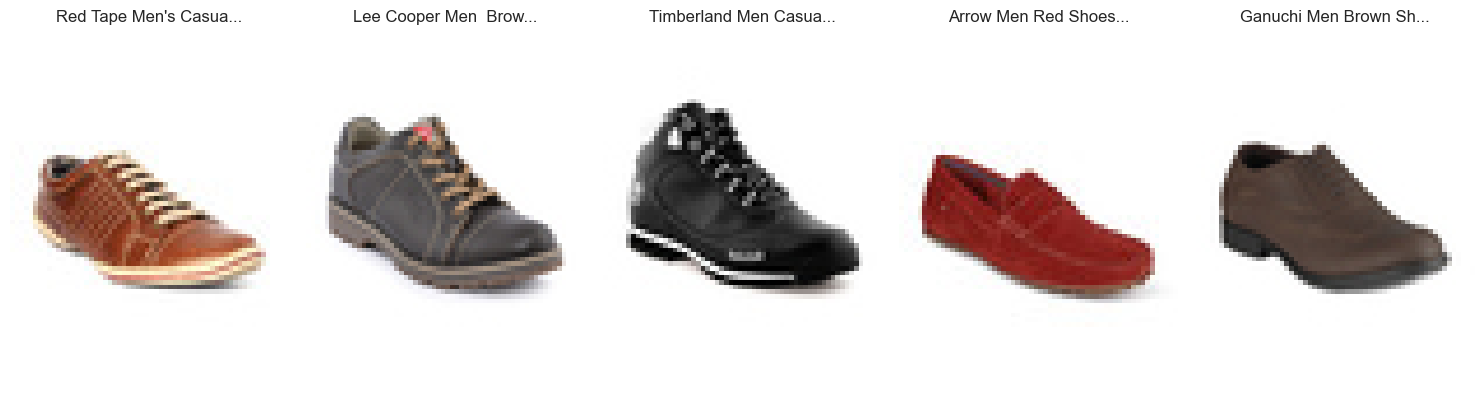

In [56]:
import pickle
import numpy as np
import os
import re
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load GRU sentiment model and tokenizer/label encoder
modelx = load_model("gru_sentiment_amazon.h5")
with open("amazon_tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)
with open("amazon_label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# Load dataset for image recommendations
df = pd.read_csv("datasets/styles_cleaned.csv")

# Define the image prediction function (assumes predict_labels exists)
def predict_and_show2(image_path):
    print("\n📸 Running image prediction and showing recommendations...\n")
    
    predicted_labels = predict_labels(image_path)
    predicted_article_type = predicted_labels.get("articleType", None)

    if not predicted_article_type:
        print("⚠️ 'articleType' not found in prediction output.")
        return

    matching_items = df[df['articleType'] == predicted_article_type]
    print(f"Found {len(matching_items)} items for articleType: {predicted_article_type}")

    if matching_items.empty:
        print("⚠️ No matching items found.")
        return

    sampled = matching_items.sample(n=min(5, len(matching_items)))

    plt.figure(figsize=(15, 5))
    for i, (_, row) in enumerate(sampled.iterrows()):
        img_path = os.path.join("datasets\\images", os.path.basename(row['path']))
        print(f"- {row['productDisplayName']} → {img_path}")
        try:
            img = Image.open(img_path)
            plt.subplot(1, 5, i + 1)
            plt.imshow(img)
            plt.title(row['productDisplayName'][:20] + '...')
            plt.axis('off')
        except Exception as e:
            print(f"Could not load image: {img_path} → {e}")

    plt.tight_layout()
    plt.show()

# Text preprocessing
def process_text_for_prediction(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\W', ' ', str(text))
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words and len(word) > 3]
    return " ".join(words)

# Sample reviews
sample_texts = ["This product is worst", "This is really good"]
sample_cleaned = [process_text_for_prediction(text) for text in sample_texts]

# Tokenize & pad
sample_seq = tokenizer.texts_to_sequences(sample_cleaned)
sample_seq_padded = pad_sequences(sample_seq, maxlen=100)

# Predict sentiment
pred_probs = modelx.predict(sample_seq_padded)
pred_classes = np.argmax(pred_probs, axis=1)
pred_labels = label_encoder.inverse_transform(pred_classes)

# Image path
image_path = "shoes.jpg"

# Main logic loop
for i, text in enumerate(sample_texts):
    sentiment = pred_classes[i]
    label = pred_labels[i]
    print(f"\n📝 Review: '{text}' → Predicted Sentiment: {label} ({sentiment})")

    if sentiment == 1:
        print("✅ Positive sentiment detected. Recommending similar items...\n")
        predict_and_show2(image_path)
    else:
        print("❌ Negative sentiment detected. Skipping image recommendation.")


Called predict_and_show with: shirt.jpg
Predicted articleType from image: Shirts
Found 3212 items for predicted label 'Shirts'

🖼️  Top 5 similar items based on predicted label:
- Highlander Men Brown Check Shirt (Shirts) → datasets\images\23202.jpg
- Wrangler Men City Work Navy Blue Shirts (Shirts) → datasets\images\10820.jpg
- Peter England Men Red Check Shirt (Shirts) → datasets\images\55608.jpg
- Wrangler Men Hard Rock Purple Shirt (Shirts) → datasets\images\29283.jpg
- Arrow Men Blue Striped Shirt (Shirts) → datasets\images\14758.jpg


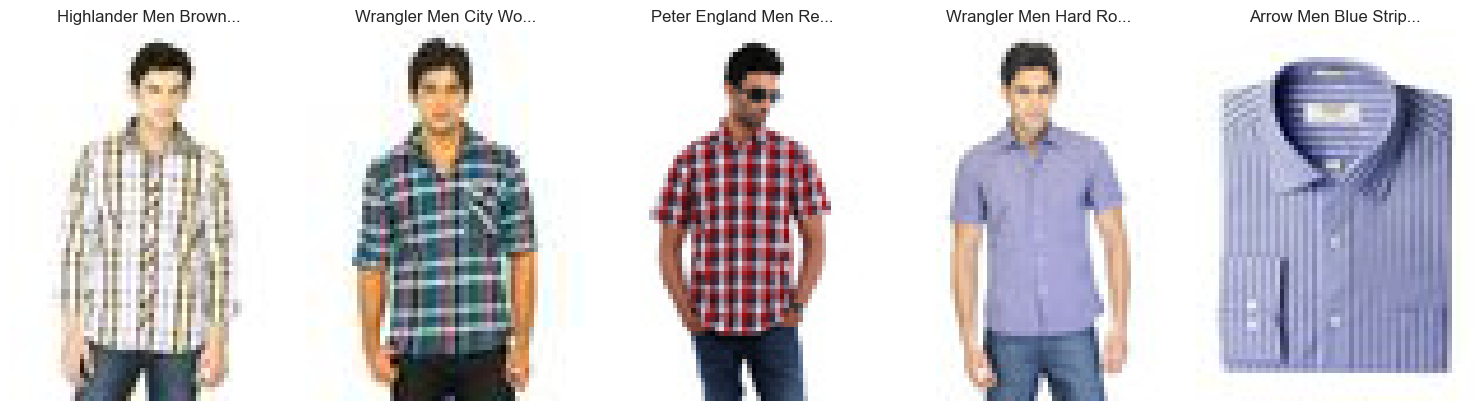

In [212]:
import pandas as pd
import random
import os
from PIL import Image
import matplotlib.pyplot as plt

# Load cleaned dataset
df = pd.read_csv("datasets/styles_cleaned.csv")

def predict_and_show2(image_path):
    print("Called predict_and_show with:", image_path)
    
    predicted_labels = predict_labels(image_path)  # Your existing function
    predicted_article_type = predicted_labels.get("articleType", None)

    if not predicted_article_type:
        print("⚠️ 'articleType' not found in prediction output.")
        return

    print(f"Predicted articleType from image: {predicted_article_type}")
    
    matching_items = df[df['articleType'] == predicted_article_type]
    print(f"Found {len(matching_items)} items for predicted label '{predicted_article_type}'")

    if matching_items.empty:
        print("⚠️ No matching items found.")
        return

    sampled = matching_items.sample(n=min(5, len(matching_items)))

    print("\n🖼️  Top 5 similar items based on predicted label:")
    
    # Show image grid
    plt.figure(figsize=(15, 5))
    for i, (_, row) in enumerate(sampled.iterrows()):
        img_path = os.path.join("datasets\\images", os.path.basename(row['path']))
        print(f"- {row['productDisplayName']} ({row['articleType']}) → {img_path}")
        
        try:
            img = Image.open(img_path)
            plt.subplot(1, 5, i + 1)
            plt.imshow(img)
            plt.title(row['productDisplayName'][:20] + '...')  # Shorten title
            plt.axis('off')
        except Exception as e:
            print(f"⚠️ Could not load image {img_path}: {e}")
    
    plt.tight_layout()
    plt.show()
predict_and_show2("shirt.jpg")